In [3]:
from tpot import TPOTClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import pandas as pd
import re
import numpy as np
import seaborn as sns
import string 
import warnings
import nltk
from sklearn.metrics import accuracy_score
warnings.filterwarnings("ignore")
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andrey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Andrey\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
msg = pd.read_csv('spam.csv',encoding='latin-1')
msg

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


## Предобработка данных

In [5]:
msg.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)
msg.rename(columns={'v1':'label','v2':'text'},inplace=True)
msg.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
for i in msg.index:
    if msg['label'][i]=='ham':
        msg['label'][i]=0
    else:
        msg['label'][i]=1
msg.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
msg.duplicated().sum

<bound method Series.sum of 0       False
1       False
2       False
3       False
4       False
        ...  
5567    False
5568    False
5569    False
5570    False
5571    False
Length: 5572, dtype: bool>

In [8]:
msg['length']=msg['text'].apply(len)
msg.head()

,label,text,length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


<AxesSubplot:xlabel='length'>

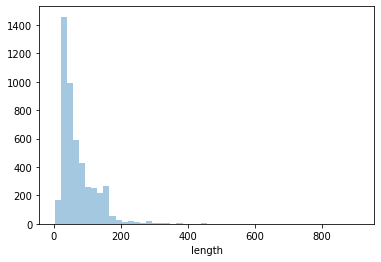

In [9]:
sns.distplot(a=msg[msg['label']==0].length,kde=False)

<AxesSubplot:xlabel='length'>

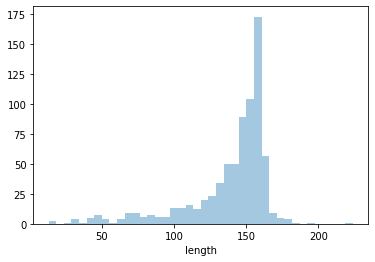

In [10]:
sns.distplot(a=msg[msg['label']==1].length,kde=False)

In [11]:
for i in range(50):
    if msg['label'][i]==1:
        print(msg['text'][i])

Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv
WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030
SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info
URGENT! You have won a 1 week FREE membership in our å£100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18
XXXMobileMovieClub: To use your credit, click the WAP link in the next txt message or c

In [12]:
msg['contain']=msg['text'].str.contains('£').map({False:0,True:1})
msg['contain']=msg['contain']|msg['text'].str.contains('%').map({False:0,True:1})
msg['contain']=msg['contain']|msg['text'].str.contains('€').map({False:0,True:1})
msg['contain']=msg['contain']|msg['text'].str.contains('\$').map({False:0,True:1})
msg['contain']=msg['contain']|msg['text'].str.contains("T&C").map({False:0,True:1})
msg['contain']=msg['contain']|msg['text'].str.contains("www|WWW").map({False:0,True:1})
msg['contain']=msg['contain']|msg['text'].str.contains("http|HTTP").map({False:0,True:1})
msg['contain']=msg['contain']|msg['text'].str.contains("https|HTTPS").map({False:0,True:1})
msg['contain']=msg['contain']|msg['text'].str.contains("@").map({False:0,True:1})
msg['contain']=msg['contain']|msg['text'].str.contains("email|Email|EMAIL").map({False:0,True:1})
msg['contain']=msg['contain']|msg['text'].str.contains("SMS|sms|FREEPHONE").map({False:0,True:1})
msg['contain']=msg['contain']|msg['text'].str.contains("\d{11}",regex=True).map({False:0,True:1})
msg['contain']=msg['contain']|msg['text'].str.contains("\d{10}",regex=True).map({False:0,True:1})
msg['contain']=msg['contain']|msg['text'].str.contains("\d{5}",regex=True).map({False:0,True:1})

msg.head()

,label,text,length,contain
0,0,"Go until jurong point, crazy.. Available only ...",111,0
1,0,Ok lar... Joking wif u oni...,29,0
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,1
3,0,U dun say so early hor... U c already then say...,49,0
4,0,"Nah I don't think he goes to usf, he lives aro...",61,0


<AxesSubplot:xlabel='contain'>

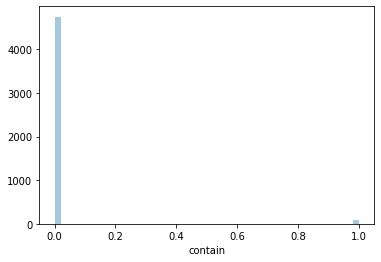

In [13]:
sns.distplot(a=msg[msg['label']==0].contain,kde=False)

<AxesSubplot:xlabel='contain'>

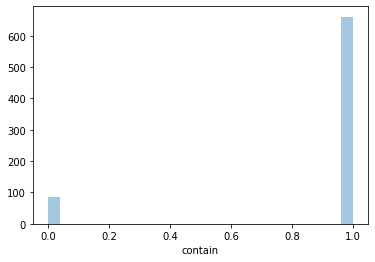

In [14]:
sns.distplot(a=msg[msg['label']==1].contain,kde=False)

In [15]:
msg['cleaned_text']=""

for i in msg.index:
    updated_list=[]
    for j in range(len(msg['text'][i])):
        if msg['text'][i][j] not in string.punctuation:
            if msg['text'][i][j].isdigit()==False:
                updated_list.append(msg['text'][i][j])
    updated_string="".join(updated_list)
    msg['cleaned_text'][i]=updated_string

msg.drop(['text'],axis=1,inplace=True)
msg.head() 

,label,length,contain,cleaned_text
0,0,111,0,Go until jurong point crazy Available only in ...
1,0,29,0,Ok lar Joking wif u oni
2,1,155,1,Free entry in a wkly comp to win FA Cup final...
3,0,49,0,U dun say so early hor U c already then say
4,0,61,0,Nah I dont think he goes to usf he lives aroun...


In [16]:
msg['token']=""

for i in msg.index:
    msg['token'][i]=re.split("\W+",msg['cleaned_text'][i].lower())

msg.head()

,label,length,contain,cleaned_text,token
0,0,111,0,Go until jurong point crazy Available only in ...,"[go, until, jurong, point, crazy, available, o..."
1,0,29,0,Ok lar Joking wif u oni,"[ok, lar, joking, wif, u, oni]"
2,1,155,1,Free entry in a wkly comp to win FA Cup final...,"[free, entry, in, a, wkly, comp, to, win, fa, ..."
3,0,49,0,U dun say so early hor U c already then say,"[u, dun, say, so, early, hor, u, c, already, t..."
4,0,61,0,Nah I dont think he goes to usf he lives aroun...,"[nah, i, dont, think, he, goes, to, usf, he, l..."


In [17]:
msg['updated_token']=""
stopwords=nltk.corpus.stopwords.words('english')

for i in msg.index:
    updated_list=[]
    for j in range(len(msg['token'][i])):
        if msg['token'][i][j] not in stopwords:
            updated_list.append(msg['token'][i][j])
    msg['updated_token'][i]=updated_list

msg.drop(['token'],axis=1,inplace=True)
msg.head()


,label,length,contain,cleaned_text,updated_token
0,0,111,0,Go until jurong point crazy Available only in ...,"[go, jurong, point, crazy, available, bugis, n..."
1,0,29,0,Ok lar Joking wif u oni,"[ok, lar, joking, wif, u, oni]"
2,1,155,1,Free entry in a wkly comp to win FA Cup final...,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,0,49,0,U dun say so early hor U c already then say,"[u, dun, say, early, hor, u, c, already, say]"
4,0,61,0,Nah I dont think he goes to usf he lives aroun...,"[nah, dont, think, goes, usf, lives, around, t..."


In [18]:
msg['lem_text']=""
wordlem=nltk.WordNetLemmatizer()

for i in msg.index:
    updated_list=[]
    for j in range(len(msg['updated_token'][i])):
        updated_list.append(wordlem.lemmatize(msg['updated_token'][i][j]))
    msg['lem_text'][i]=updated_list 

msg.drop(['updated_token'],axis=1,inplace=True)
msg.head()

,label,length,contain,cleaned_text,lem_text
0,0,111,0,Go until jurong point crazy Available only in ...,"[go, jurong, point, crazy, available, bugis, n..."
1,0,29,0,Ok lar Joking wif u oni,"[ok, lar, joking, wif, u, oni]"
2,1,155,1,Free entry in a wkly comp to win FA Cup final...,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,0,49,0,U dun say so early hor U c already then say,"[u, dun, say, early, hor, u, c, already, say]"
4,0,61,0,Nah I dont think he goes to usf he lives aroun...,"[nah, dont, think, go, usf, life, around, though]"


In [19]:
msg['final_text']=""

for i in msg.index:
    updated_string=" ".join(msg['lem_text'][i])
    msg['final_text'][i]=updated_string

msg.drop(['cleaned_text','lem_text'],axis=1,inplace=True)
msg.head(20)
msg.to_csv('clean_data_to_nw.csv')

In [20]:
y=pd.DataFrame(msg.label)
x=msg.drop(['label'],axis=1)

In [21]:
x_train,x_val,y_train,y_val=train_test_split(x,y,train_size=0.8,test_size=0.2,random_state=0)

In [22]:
cv=CountVectorizer(max_features=5000)
temp_train=cv.fit_transform(x_train['final_text']).toarray()
temp_val=cv.transform(x_val['final_text']).toarray()

tf=TfidfTransformer()
temp_train=tf.fit_transform(temp_train)
temp_val=tf.transform(temp_val)
temp_train=pd.DataFrame(temp_train.toarray(),index=x_train.index)
temp_val=pd.DataFrame(temp_val.toarray(),index=x_val.index)
x_train=pd.concat([x_train,temp_train],axis=1,sort=False)
x_val=pd.concat([x_val,temp_val],axis=1,sort=False)

x_train.head()

,length,contain,final_text,0,1,2,3,4,5,6,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
1114,60,0,nothis kallis home groundamla home town durban,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3589,69,0,escape theatre going watch kavalan minute,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3095,110,0,walked mom right stagwood pas right winterston...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1012,46,0,dunno close oredi ìï v fan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.384573,0.0,0.0,0.0,0.0,0.0
3320,22,0,yo im right yo work,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [23]:
x_train.drop(['final_text'],axis=1,inplace=True)
x_val.drop(['final_text'],axis=1,inplace=True)

x_train.head()

,length,contain,0,1,2,3,4,5,6,7,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
1114,60,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3589,69,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3095,110,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1012,46,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.384573,0.0,0.0,0.0,0.0,0.0
3320,22,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [24]:
y_train=y_train.astype(int)
y_val=y_val.astype(int)

In [25]:
model=RandomForestClassifier(n_estimators=100,random_state=0)
model.fit(x_train,y_train)
y_preds=model.predict(x_val)
print("Random Forest:",accuracy_score(y_val,y_preds))

Random Forest: 0.9838565022421525


In [26]:
parameters = { 'hidden_layer_sizes': range(1,125,1),
               'activation': {'identity', 'logistic', 'tanh', 'relu'},
               'batch_size': range(1,25,1),
               'max_iter':range(1,100,1),
               'verbose':{'True'},
               }

In [29]:
tpot_classifier = TPOTClassifier(generations= 100,
                                 population_size= 100,
                                 verbosity= 3,
                                n_jobs = -1,
                                max_time_mins = 1280,
                                max_eval_time_mins =5,
                                config_dict = {'sklearn.neural_network.MLPClassifier':parameters},
                                 periodic_checkpoint_folder = r"D:/Учеба",
                                cv = 5,
                                scoring = 'accuracy')
tpot_classifier.fit(x_train,y_train) 
print(tpot_classifier.score(x_val, y_val))
tpot_classifier.export('target nw for spam 2.0.py')

0.9883408071748879
